# Notebook dedicated to Implement event selection criteria using observables to obtain antinu like events

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn

import glob
import re
import os
import itertools
import pickle

In [2]:
def extract_file_number(filepath):
    """
    Extrae el número entre 'output_' y '_<var>.npy' desde el nombre del archivo.
    Ejemplo: output_104_clockCount50.npy → 104
    """
    filename = os.path.basename(filepath)
    match = re.search(r'output_(\d+)_\w+\.npy', filename)
    return int(match.group(1)) if match else -1  # -1 para poner errores al final


In [3]:
def posr_cal(x, y, z):
    dr = np.sqrt(x**2 + y**2 + z**2)
    return dr

In [4]:
def split_list(lista, n):
    """
    Divide una lista en `n` sublistas de tamaño lo más equilibrado posible.
    """
    k, m = divmod(len(lista), n)
    return [lista[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

# Load data and Extract Data

In [29]:
# Read directories paths and split Data to be loaded ------------------------------------------------------------------------------
main_dir_files = 'E:/Data/antinu_realdata/gold/numpy_files/analysis/'
#name of variables to be used for the antinu analysis
var_read_name_list = ['energy', 'posx', 'posy', 'posz', 'clockCount50']

#Code settings -------------------
#Data-split number:
n_split = 4

#Primary energy and FV cuts:
en_cut_inf = 1.6
en_cut_sup = 8.0
posr_cut_sup = 5500

# Antinu-finder algorithm:
alpha = 9
tau = 215
dt_sup_lim = 1000
dt_inf_lim = 0.5 # (0.5) -> To avoid retriggers

dr_sup_lim = 600 
dr_inf_lim = 0

energy_delay_sup_cut = 3.5
energy_delay_inf_cut = 1.8

#Dictionary Out Settings:
save_dict = True
dict_save_dir = 'antinu_dict/'
dict_fname = f'antinu_dict_delta_t_{dt_inf_lim}_{dt_sup_lim}(mcs)_dr_{dr_inf_lim}_{dr_sup_lim}(mm)_en_{en_cut_inf}_{en_cut_sup}(MeV)_R_{posr_cut_sup}(mm)_en_delay_{energy_delay_inf_cut}_{energy_delay_sup_cut}(MeV)'

#---------------------------------

#Information to save: Dictionary with the observables of interest for antinu candidates
antinu_dict = {'energy_prompt': [],
			   'energy_delay': [],
			   'delta_t': [],
			   'delta_r': []}

energy_cut = []
posr_cut = []

#create the full directory list for each of the var_read_name_list by just adding '_summary' to the end of the names
for var_i in var_read_name_list:
    locals()['flist_' + var_i] = glob.glob(os.path.join(main_dir_files, var_i + '_summary', '*.npy'))
    locals()['flist_' + var_i].sort(key=extract_file_number)  # ordena por número en 'output_*_<var>.npy'

    #Create the splitten list of observables
    locals()['flist_split_' + var_i] = split_list(locals()['flist_' + var_i], n_split)

#Iteration over files -------------------------------------------------------------------------------------------------------------------
for i_dx in range(n_split):
    
    print(f'reading spliten files in iteration {i_dx}')
    #create a temporal dictionary with empty lists to be filled with the observable values:
    temp_obs_dict = {var_i: [] for var_i in var_read_name_list}
    
    #Extract sublist with the directory of observables
    for var_i in var_read_name_list:
        print(f'reading directories of observable {var_i}')
        dir_obs_i = locals()['flist_split_' + var_i][i_dx]  #extract the directories of the observabel var_i

        #Iterate over the files of the observable var_i and save info in temporal dictionary
        for file_i in dir_obs_i:
            arr = np.load(file_i, mmap_mode='r')
            temp_obs_dict[var_i].append(arr)

    #Now take the keys of the temp_obs_dict and transform data to numpy arrays and clean memory
    for var_i in var_read_name_list:
        print(f'flattening numpy array {var_i}')
        locals()[var_i] = np.concatenate((temp_obs_dict[var_i]))  #Try to flatten the list of numpy arrays within the dictionary
        
        if var_i == 'posx' or var_i == 'posy' or var_i == 'posz':
            print(f'transforming data type {var_i}')
            locals()[var_i] = locals()[var_i].astype(np.float32)
            
        temp_obs_dict[var_i] = None

    #Compute radial position of events
    print('computing posr ...')
    posr = posr_cal(posx, posy, posz)

    # Selection of events based on Energy and FV cuts ------------------------------------------------
    print('performing energy and FV cuts')
    general_condition = (energy >= en_cut_inf) & (energy <= en_cut_sup) & (posr <= posr_cut_sup)
    
    energy = energy[general_condition]
    energy_cut.append(energy)
    
    posr = posr[general_condition]
    posr_cut.append(posr)
    
    posx = posx[general_condition]
    posy = posy[general_condition]
    posz = posz[general_condition]
    
    clockCount50 = clockCount50[general_condition]

    #Create plots of the energy spectrum and radial distribution and save

    # Antinu-finder algorithm ------------------------------------------------------------------------
    print('Getting in antinu finder')
    #Data to save
    delta_t = []
    delta_r = []
    
    energy_prompt = []
    energy_delay = []
    
    N_ev = energy.shape[0]
    
    for ev_i in range(N_ev):
    
        delay_index = ev_i + 1
        #print('In event', ev_i)
    
        #Suspected promt event observables
        t1 = clockCount50[ev_i]
        posx1 = posx[ev_i]
        posy1 = posy[ev_i]
        posz1 = posz[ev_i]
        energy_1 = energy[ev_i]
        
        try:
            #Suspected delayed
            t2 = clockCount50[delay_index]
            posx2 = posx[delay_index]
            posy2 = posy[delay_index]
            posz2 = posz[delay_index]
            energy_2 = energy[delay_index]
            
            #Evaluate the dr and dt between events
            dx = posx2 - posx1
            dy = posy2 - posy1
            dz = posz2 - posz1
            dr = np.sqrt(dx**2 + dy**2 + dz**2)
            dt = t2 - t1
            
        except IndexError:
            continue
    
        #print('intial prompt_i: ', ev_i)
        #print('intial delay_i: ', delay_index)
           
        #Start looking for a delay event within a windows alpha times tau
        while (dt > 0) and (dt <= alpha*tau):
            
            #print(f'prompt_i within dt interval. index = {ev_i}, t1 = {t1}')
            #print(f'delay_i within dt interval. index = {delay_index}, t2 = {t2}')
            #print(f'dt within interval = {dt}')
    
            # If the dr coincide with the expected values, then save the observables of interest and break the while
            #if (dr >= dr_exp - dr_unc) and (dr <= dr_exp + dr_unc) and (dt > 0) and (dt <= alpha*tau) and (energy_2 >= energy_delay_inf_cut) and (energy_2 <= energy_delay_sup_cut):
            if (dr >= dr_inf_lim) and (dr <= dr_sup_lim) and (dt > dt_inf_lim) and (dt <= dt_sup_lim) and (energy_2 >= energy_delay_inf_cut) and (energy_2 <= energy_delay_sup_cut):
                print('Pair Found')
                print(f'dr: {dr} and dt: {dt}')
                delta_t.append(dt)
                delta_r.append(dr)
                energy_prompt.append(energy_1)
                energy_delay.append(energy_2)
    
                break
            # Evolve the delay index if the condition is not fulfilled
            delay_index += 1
    
            # Look for the next Suspected delayed
            try:
                t2 = clockCount50[delay_index]
                #print(f'actual prompt index = {ev_i}')
                #print(f'new delay candidate: index = {delay_index}, t2 ={t2}')
                posx2 = posx[delay_index]
                posy2 = posy[delay_index]
                posz2 = posz[delay_index]
                energy_2 = energy[delay_index]
        
                #Evaluate the dr and dt between events
                dx = posx2 - posx1
                dy = posy2 - posy1
                dz = posz2 - posz1
                dr = np.sqrt(dx**2 + dy**2 + dz**2)
                dt = t2 - t1
                #print(f'new dt = {dt}')
            except IndexError:
                break

    # Save the outputs of the antinu finder in the outer antinu dictionary
    print('saving observables in antinu dictionary')
    #antinu_dict['all_energy'].append(list(energy))
    #antinu_dict['all_posr'].append(list(posr))
    antinu_dict['energy_prompt'].append(energy_prompt)
    antinu_dict['energy_delay'].append(energy_delay)
    antinu_dict['delta_t'].append(delta_t)
    antinu_dict['delta_r'].append(delta_r)

#transform the dictionary entries to flatten numpy array
#antinu_dict['all_energy'] = np.array(list(itertools.chain.from_iterable(antinu_dict['all_energy'])))
#antinu_dict['all_posr'] = np.array(list(itertools.chain.from_iterable(antinu_dict['all_posr'])))
antinu_dict['energy_prompt'] = np.array(list(itertools.chain.from_iterable(antinu_dict['energy_prompt'])))
antinu_dict['energy_delay'] = np.array(list(itertools.chain.from_iterable(antinu_dict['energy_delay'])))
antinu_dict['delta_t'] = np.array(list(itertools.chain.from_iterable(antinu_dict['delta_t'])))
antinu_dict['delta_r'] = np.array(list(itertools.chain.from_iterable(antinu_dict['delta_r'])))

#save dictionary:
if save_dict:
    with open(dict_save_dir + dict_fname + '.pkl', 'wb') as f:
        pickle.dump(antinu_dict, f)

# Call the observables by their names and flat the lists
energy_cut = np.concatenate(energy_cut)
posr_cut = np.concatenate(posr_cut)
energy_prompt = antinu_dict['energy_prompt']
energy_delay = antinu_dict['energy_delay']
delta_t = antinu_dict['delta_t']
delta_r = antinu_dict['delta_r']

reading spliten files in iteration 0
reading directories of observable energy
reading directories of observable posx
reading directories of observable posy
reading directories of observable posz
reading directories of observable clockCount50
flattening numpy array energy
flattening numpy array posx
transforming data type posx
flattening numpy array posy
transforming data type posy
flattening numpy array posz
transforming data type posz
flattening numpy array clockCount50
computing posr ...
performing energy and FV cuts
Getting in antinu finder
Pair Found
dr: 562.9648745561598 and dt: 101.0
Pair Found
dr: 132.92749713883316 and dt: 138.0
saving observables in antinu dictionary
reading spliten files in iteration 1
reading directories of observable energy
reading directories of observable posx
reading directories of observable posy
reading directories of observable posz
reading directories of observable clockCount50
flattening numpy array energy
flattening numpy array posx
transforming da

# Observe Raw Plots with Primal Cuts

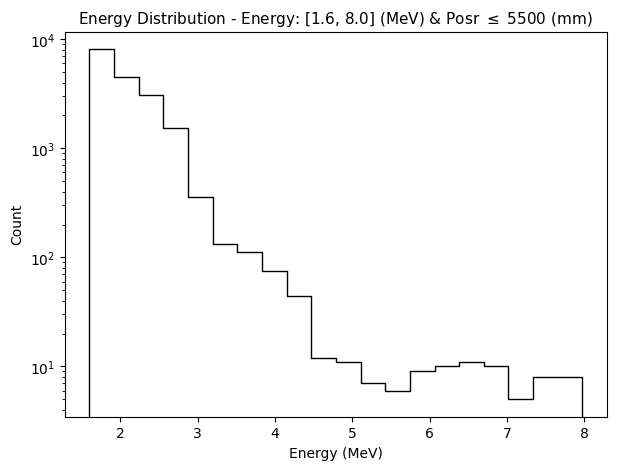

In [21]:
plt.figure(figsize=(7,5))

sn.histplot(energy_cut, bins = 20, color = 'black', element = 'step', alpha = 0)
plt.xlabel('Energy (MeV)')
plt.title(fr'Energy Distribution - Energy: [{en_cut_inf}, {en_cut_sup}] (MeV) & Posr $\leq$ {posr_cut_sup} (mm)', fontsize = 11)
plt.yscale('log')

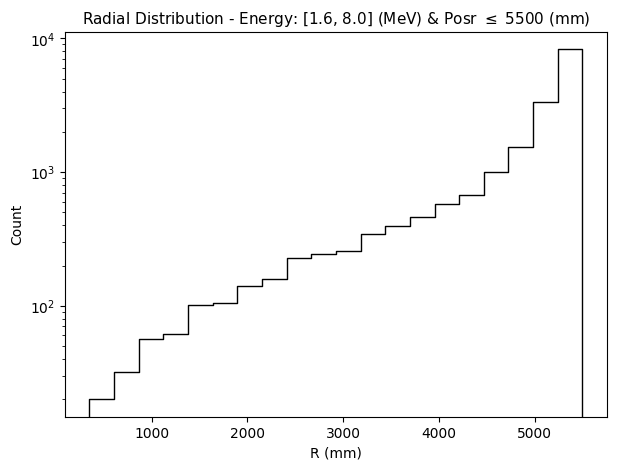

In [22]:
plt.figure(figsize=(7,5))
sn.histplot(posr_cut, bins = 20, color = 'black', element = 'step', alpha = 0)
plt.xlabel('R (mm)')
plt.title(rf'Radial Distribution - Energy: [{en_cut_inf}, {en_cut_sup}] (MeV) & Posr $\leq$ {posr_cut_sup} (mm)', fontsize = 11)
plt.yscale('log')

#Main selection Criteria for all events:
en_inf_cut = 0.5
en_sup_cut = 8

posr_cut = 5500

mask_cut = 0x2100000042C2

energy_cut_condition = (energy_analysis >= en_inf_cut) & (energy_analysis <= en_sup_cut)
posr_cut_condition = (posr_analysis <= posr_cut)
dcFlag_cut_condition = ((int(mask_cut) & dcFlagged_analysis) == int(mask_cut))

general_cut_condition = (energy_cut_condition) & (posr_cut_condition)# & dcFlag_cut_condition)

#Select observables within this cuts.
energy_cut = energy_analysis[general_cut_condition]
posx_cut = posx_analysis[general_cut_condition]
posy_cut = posy_analysis[general_cut_condition]
posz_cut = posz_analysis[general_cut_condition]
time_clock50_cut = clockCount50_analysis[general_cut_condition]

In [23]:
energy_delay.shape

(27,)

In [24]:
energy_prompt.shape

(27,)

# 5 - Plots

## 5.1 - Energy Spectrum

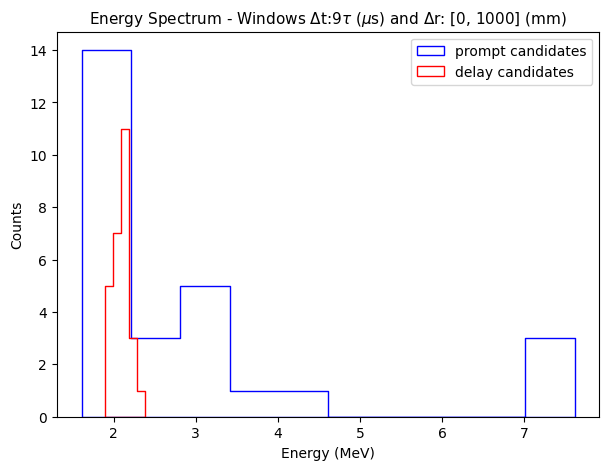

In [25]:
binwidth_prompt = 0.6
binwidth_delay = 0.1

plt.figure(figsize = (7,5))
sn.histplot(energy_prompt, binwidth = binwidth_prompt, color = 'b', element = 'step', alpha = 0, label = 'prompt candidates')
sn.histplot(energy_delay, binwidth = binwidth_delay, color = 'r', element = 'step', alpha = 0, label = 'delay candidates')
plt.legend(loc = 'best')

plt.xlabel('Energy (MeV)')
plt.ylabel(f'Counts')

#plt.yscale('log')

plt.title(rf'Energy Spectrum - Windows $\Delta$t:{alpha}$\tau$ ($\mu$s) and $\Delta$r: [{dr_inf_lim}, {dr_sup_lim}] (mm)', fontsize = 11)

plt.show()

## 5.2 - $\Delta$t

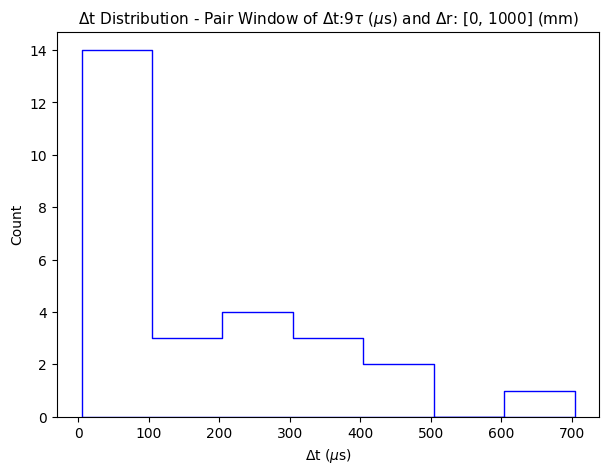

In [26]:
plt.figure(figsize = (7,5))

sn.histplot(delta_t, bins = 7, color = 'b', element = 'step', alpha = 0)

plt.xlabel(r'$\Delta$t ($\mu$s)')
plt.title(rf'$\Delta$t Distribution - Pair Window of $\Delta$t:{alpha}$\tau$ ($\mu$s) and $\Delta$r: [{dr_inf_lim}, {dr_sup_lim}] (mm)', fontsize = 11)

plt.show()

## 5.3 - $\Delta$r

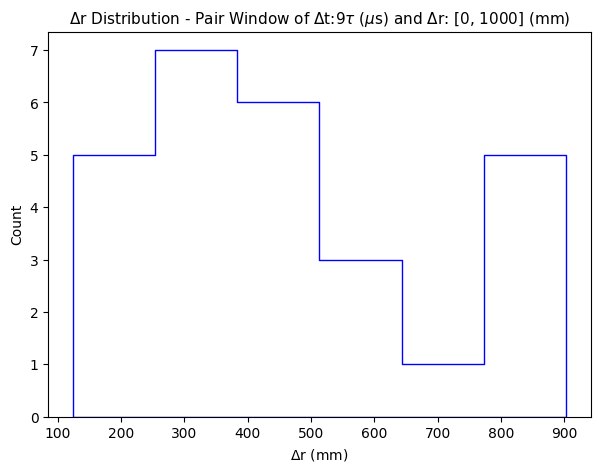

In [27]:
plt.figure(figsize = (7,5))

sn.histplot(delta_r, bins = 6, color = 'b', element = 'step', alpha = 0)

plt.xlabel(r'$\Delta$r (mm)')
plt.title(rf'$\Delta$r Distribution - Pair Window of $\Delta$t:{alpha}$\tau$ ($\mu$s) and $\Delta$r: [{dr_inf_lim}, {dr_sup_lim}] (mm)', fontsize = 11)

plt.show()

# Code line para limpiar información innecesariamente guardada en los diccionarios

In [39]:
#Primary energy and FV cuts:
en_cut_inf = 1.0
en_cut_sup = 8.0
posr_cut_sup = 5500

# Antinu-finder algorithm:
alpha = 9
tau = 215
dt_sup_lim = 1000
dt_inf_lim = 0.5 # (0.5) -> To avoid retriggers

dr_sup_lim = 600 
dr_inf_lim = 0

energy_delay_sup_cut = 3.5
energy_delay_inf_cut = 1.8


dict_read_dir = 'antinu_dict/'
dict_fname = f'antinuR_dict_delta_t_{dt_inf_lim}_{dt_sup_lim}(mcs)_dr_{dr_inf_lim}_{dr_sup_lim}(mm)_en_{en_cut_inf}_{en_cut_sup}(MeV)_R_{posr_cut_sup}(mm)_en_delay_{energy_delay_inf_cut}_{energy_delay_sup_cut}(MeV)'

flist_dir = glob.glob(dict_read_dir + '*.pkl')

for file_dir_i in flist_dir:

    #Extract the base name of the dictionary. Useful to resave the file with exactly the same name
    fname_base = os.path.basename(file_dir_i)

    #Open the dictionary
    with open(file_dir_i, 'rb') as f:
        antinu_dict = pickle.load(f)

    #delete unnecessary
    del antinu_dict['all_energy']
    del antinu_dict['all_posr']

    #save information
    with open(dict_save_dir + fname_base, 'wb') as f:
        pickle.dump(antinu_dict, f)